# Real or Not? NLP with Disaster Tweets---Sentiment Classification Using RNN

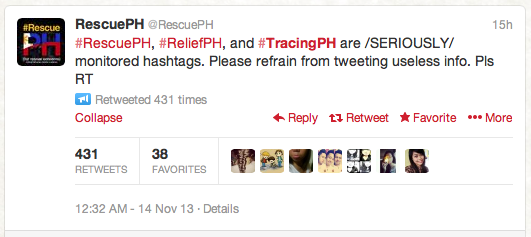

## Introduction

- The purpose of this project is to predict which Tweets are about real disasters and which ones are not.

### Methodology

- Word embedding: pre_trained Word2vec model 
- Recurrent Neural Network: LSTM/GRU models

- Thanks for the inspiration of this blog:
https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

### Dataset

There are 7613 tweets in the training set and 3263 tweets in the testing set. 
Each sample in the train and test set has the following information:

- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from
- keyword - a particular keyword from the tweet
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

## Import packages and load data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/twitter disaster/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/twitter disaster/test.csv')

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train.shape

(7613, 5)

In [98]:
test.shape

(3263, 4)

In [99]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train.keyword.isna().sum()

61

In [8]:
train.location.isna().sum()

2533

## EDA

- create a table to count how many times each keyword showing in the dataset

In [0]:
kw = train.keyword.value_counts().head(10).reset_index()
kw.columns=['keyword','frequency']

- create a table to count how many times each location showing in the dataset

In [0]:
loc = train.location.value_counts().head(10).reset_index()
loc.columns=['location','frequency']

- create a function to plot the frequence table

In [0]:
def plot_frequency(data,title):
    plt.figure(figsize=(10,6))
    plt.title('Most Frequent '+title,fontsize=20,fontweight='bold', pad=20)
    sns.barplot(x=title,y='frequency',data=data,palette='Set2')

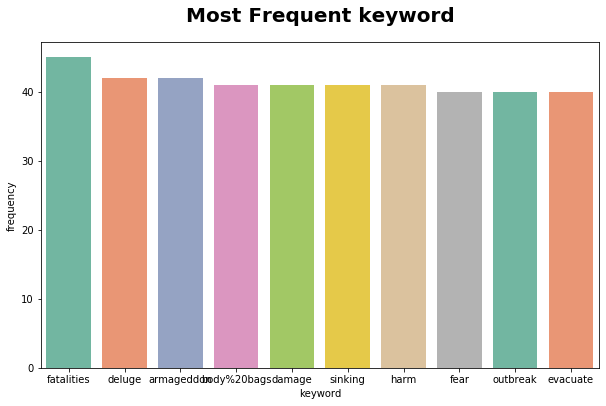

In [12]:
plot_frequency(kw,'keyword')

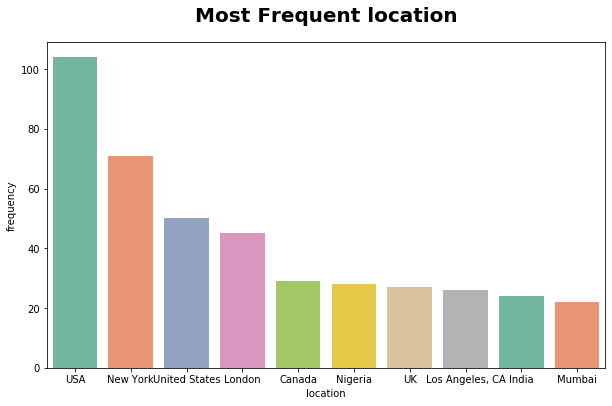

In [13]:
plot_frequency(loc,'location')

In [14]:
train.keyword.nunique()

221

- create a table to count the number of "label=1" by each keywords

In [0]:
imp = train.groupby('keyword').sum().reset_index().sort_values('target',ascending=False).head(20)

In [0]:
wdlist = list(imp.keyword)

- create a function to draw the word cloud

In [0]:
def getwordcloud(ls):
  word = ' '
  for i in range(len(ls)):
    word = word + ls[i] + ' '
  wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(word) 
  plt.figure(figsize = (10, 5), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.show() 

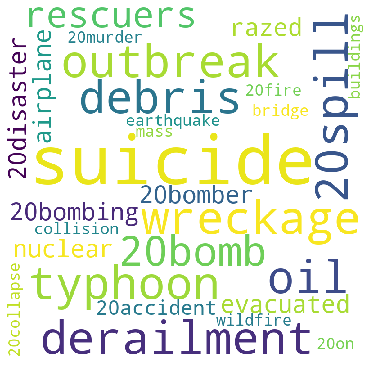

In [18]:
getwordcloud(wdlist)

- From the word cloud, we can see that texts including 'suicide','outbreak','debris','derailment','wreckage' and 'typhoon' are most likely to be regarded as disaster tweets.

## Data Preprocessing

### Word2Vec --- word embedding

In [19]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

- The function below is to preprocess the tweets into word list that we are able to transform them into numerical vectors.

In [0]:
def text_processing(data):
    tweets = list()
    lines = data.text.values.tolist()
    """
    create a word list：
    1. convert all the words in the tweets to lower case
    2. remove punctuation from each word
    3. remove remaining tokens that are not alphabetic
    4. filter out stop words
    """
    for line in lines:
        tokens = word_tokenize(line)
        
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        
        # remove punctuation from each word
        table = str.maketrans('','',string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        
        # filter out stop words
        my_stopwords = ['http','https','amp','nt']
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words and word not in my_stopwords]
        
        tweets.append(words)
    return tweets

In [0]:
train_text = text_processing(train)

In [0]:
test_text = text_processing(test)

In [23]:
len(train_text)

7613

In [24]:
len(test_text)

3263

### Load Pre_trained Word2vec model 

In [0]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300") # load 300-dimension word vectors
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [26]:
wv_from_bin = load_word2vec()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Loaded vocab size 3000000


- This model would generate 3 millon embeddings each with length 300 
- These vectors represent a large vocabulary list of 3 million words

### Use Pre-trained Embedding by Tokenizer API in keras

- Build the embedding layer

In [0]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [0]:
def get_pad(data):
  # vectorize the text
  tokenizer_obj = Tokenizer()
  tokenizer_obj.fit_on_texts(data)
  sequences = tokenizer_obj.texts_to_sequences(data)

  # pad sequences
  word_index = tokenizer_obj.word_index
  print('Found %s unique tokens' % len(word_index))

  # find the max lengh of each sequence
  find_max=[]
  for i in range(len(sequences)):
      find_max.append(len(sequences[i]))
  max_length = max(find_max)

  text_pad = pad_sequences(sequences,maxlen=max_length)
  print('Shape of text tensor:',text_pad.shape)
  return text_pad

In [0]:
def get_wordindex(data):
  # vectorize the text
  tokenizer_obj = Tokenizer()
  tokenizer_obj.fit_on_texts(data)
  word_index = tokenizer_obj.word_index
  return word_index

In [0]:
def get_maxlength(data):
  # vectorize the text
  tokenizer_obj = Tokenizer()
  tokenizer_obj.fit_on_texts(data)
  sequences = tokenizer_obj.texts_to_sequences(data)

  # find the max lengh of each sequence
  find_max=[]
  for i in range(len(sequences)):
      find_max.append(len(sequences[i]))
  max_length = max(find_max)

In [0]:
def get_embedding(word_index):
    
  # create a matrix for the vocabulary of our training set, the row represents each vocabulary,
  # the column represents each dimention we created for this vocabulary
  embedding = np.zeros((len(word_index)+1, 300))
  for word in word_index.keys():
      if word in wv_from_bin.vocab.keys():
          embedding[word_index[word], :] = np.array(wv_from_bin.word_vec(word))
      else:
          embedding[word_index[word], :] = np.random.randn(300)
  return embedding

In [30]:
train_pad = get_pad(train_text)

Found 16641 unique tokens
Shape of text tensor: (7613, 23)


- create the embedding matrix 

In [0]:
word_index = get_wordindex(train_text)
embedding = get_embedding(word_index)
max_length = get_maxlength(train_text)

## Model

In [0]:
from keras.models import Sequential
from keras.layers import Dense,Embedding, LSTM, GRU,Bidirectional, BatchNormalization, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

In [ ]:
- 

In [0]:
embedding_dim = 300
Embedding_layer = Embedding((len(word_index)+1),embedding_dim,
                    embeddings_initializer=Constant(embedding),
                    input_length=max_length,
                    trainable = False)

### Model1 ---  Bidirectional GRU

In [0]:
model=Sequential()
model.add(Embedding_layer)
model.add(Bidirectional(GRU(32,dropout=0.2,recurrent_dropout=0.1,return_sequences=True)))
model.add(Bidirectional(GRU(32,dropout=0.2,recurrent_dropout=0.1)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         4992600   
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 64)          63936     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 64)                18624     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,075,225
Trainable params: 82,625
Non-trainable params: 4,992,600
_________________________________________________________________


In [126]:
model.fit(train_pad,train.target.values,batch_size=128,epochs=15, validation_split = 0.2,verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/15
 - 14s - loss: 0.6129 - acc: 0.6548 - val_loss: 0.4900 - val_acc: 0.7768
Epoch 2/15
 - 6s - loss: 0.4800 - acc: 0.7790 - val_loss: 0.4649 - val_acc: 0.7905
Epoch 3/15
 - 6s - loss: 0.4398 - acc: 0.8030 - val_loss: 0.4680 - val_acc: 0.7892
Epoch 4/15
 - 6s - loss: 0.4195 - acc: 0.8159 - val_loss: 0.4723 - val_acc: 0.7925
Epoch 5/15
 - 6s - loss: 0.4027 - acc: 0.8281 - val_loss: 0.4759 - val_acc: 0.7820
Epoch 6/15
 - 6s - loss: 0.3840 - acc: 0.8337 - val_loss: 0.4859 - val_acc: 0.7846
Epoch 7/15
 - 6s - loss: 0.3612 - acc: 0.8443 - val_loss: 0.4986 - val_acc: 0.7748
Epoch 8/15
 - 6s - loss: 0.3427 - acc: 0.8606 - val_loss: 0.5065 - val_acc: 0.7833
Epoch 9/15
 - 6s - loss: 0.3301 - acc: 0.8614 - val_loss: 0.5092 - val_acc: 0.7859
Epoch 10/15
 - 6s - loss: 0.3141 - acc: 0.8747 - val_loss: 0.5211 - val_acc: 0.7899
Epoch 11/15
 - 6s - loss: 0.2929 - acc: 0.8847 - val_loss: 0.5367 - val_acc: 0.7820
Epoch 12/15
 - 6s - loss: 0.2712 - a

### Model2 --- Bidirectional LSTM

In [ ]:
model2=Sequential()
model2.add(Embedding_layer)
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(256)))
model2.add(Dropout(0.2))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [120]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         4992600   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 512)               1140736   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)             

In [123]:
model2.fit(train_pad,train.target.values,batch_size=128,epochs=15, validation_split = 0.2,verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
 - 38s - loss: 0.6516 - acc: 0.7021 - val_loss: 0.5349 - val_acc: 0.7446
Epoch 2/10
 - 30s - loss: 0.4909 - acc: 0.7783 - val_loss: 0.5735 - val_acc: 0.7557
Epoch 3/10
 - 31s - loss: 0.4422 - acc: 0.8028 - val_loss: 0.5459 - val_acc: 0.7630
Epoch 4/10
 - 31s - loss: 0.3896 - acc: 0.8294 - val_loss: 0.5365 - val_acc: 0.7577
Epoch 5/10
 - 31s - loss: 0.3465 - acc: 0.8507 - val_loss: 0.5555 - val_acc: 0.7682
Epoch 6/10
 - 30s - loss: 0.3247 - acc: 0.8585 - val_loss: 0.5973 - val_acc: 0.7485
Epoch 7/10
 - 31s - loss: 0.2896 - acc: 0.8755 - val_loss: 0.6645 - val_acc: 0.7518
Epoch 8/10
 - 30s - loss: 0.2708 - acc: 0.8883 - val_loss: 0.6383 - val_acc: 0.7551
Epoch 9/10
 - 31s - loss: 0.2438 - acc: 0.8982 - val_loss: 0.6772 - val_acc: 0.7557
Epoch 10/10
 - 31s - loss: 0.2244 - acc: 0.9074 - val_loss: 0.6951 - val_acc: 0.7275


## Predict

In [127]:
test_pad = get_pad(test_text)

Found 9844 unique tokens
Shape of text tensor: (3263, 22)


In [0]:
preds = model.predict(test_pad)

In [0]:
predictions = np.where(preds >= 0.9,1,0)

In [0]:
test_id = test.id

In [146]:
output = pd.DataFrame({'id':test_id,'target':list(predictions)})
output['target'] = output['target'].str.get(0)
output.head()

,id,target
0,0,1
1,2,1
2,3,0
3,9,0
4,11,0


In [147]:
output.shape

(3263, 2)

In [0]:
output.to_csv('/content/drive/My Drive/Colab Notebooks/twitter disaster/output.csv', sep=',', encoding='utf-8')